References :

https://github.com/kbardool/keras-frcnn.git

https://github.com/Cartucho/mAP

https://medium.com/comet-app/review-of-deep-learning-algorithms-for-object-detection-c1f3d437b852

https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a

## Imports/mounts

In [1]:
!pip install keras==2.1.6

     |████████████████████████████████| 348kB 1.3MB/s 
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


In [0]:
import numpy as np
import time
import sys
import os
import random
from skimage import io
import pandas as pd
from matplotlib import pyplot as plt
from shutil import copyfile

import cv2
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [111]:
import shutil
shutil.copy("drive/My Drive/Internship - sample damage labelling 600 images.zip", '/content')

'keras-frcnn/model_frcnn (1).hdf5'

In [0]:
!unzip "Internship - sample damage labelling 600 images.zip" -d 'data'

In [0]:
!git clone https://github.com/kbardool/keras-frcnn.git

Cloning into 'keras-frcnn'...
remote: Enumerating objects: 589, done.
remote: Total 589 (delta 0), reused 0 (delta 0), pack-reused 589
Receiving objects: 100% (589/589), 178.49 KiB | 4.96 MiB/s, done.
Resolving deltas: 100% (396/396), done.


In [0]:
#!git clone https://github.com/Cartucho/mAP

## Data

In [0]:
# function to read xml annotations

import xml.etree.ElementTree as ET


def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text
        classname = boxes.find("name").text

        ymin, xmin, ymax, xmax = None, None, None, None

        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)

        list_with_single_boxes = [filename, xmin, ymin, xmax, ymax, classname]   # [classname, xmin, ymin, xmax, ymax] for test annot
        list_with_all_boxes.append(list_with_single_boxes)

    return list_with_all_boxes

Test plot

In [67]:
boxes = read_content("data/Internship/annot_chem4/akhand_b43_157.xml")
boxes

[['akhand_b43_157.jpg', 50, 216, 91, 270, 'Dislocation'],
 ['akhand_b43_157.jpg', 313, 279, 377, 326, 'Tear']]

In [0]:
img = io.imread('data/Internship/images_chem4/akhand_b43_157.jpg')

(480, 640, 3)


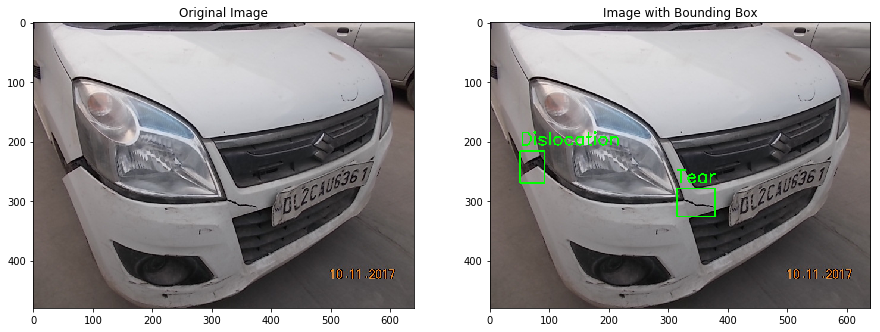

In [69]:
height, width, _ = img.shape
print(img.shape)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img)

img_bbox = img.copy()
for i in range(len(boxes)):
    xmin = boxes[i][1]
    xmax = boxes[i][3]
    ymin = boxes[i][2]
    ymax = boxes[i][4]
    
    class_name = boxes[i][5]
    cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_bbox,class_name,(xmin,ymin-10), font, 1,(0,255,0),2)
plt.subplot(1,2,2)
plt.title('Image with Bounding Box')
plt.imshow(img_bbox)
plt.show()

Looks fine !

In [0]:
base_path = 'data/Internship'

In [0]:
train_path = os.path.join('keras-frcnn/', 'train_images')
os.mkdir(train_path)
test_path = os.path.join('keras-frcnn/', 'test_images')
os.mkdir(test_path)

all_imgs = os.listdir(os.path.join(base_path, 'images_chem4'))
random.seed(1)
random.shuffle(all_imgs)

train_imgs = all_imgs[:551]
test_imgs = all_imgs[551:]

# Copying train images to train directory
for j in range(len(train_imgs)):
    original_path = os.path.join(os.path.join(base_path, 'images_chem4'), train_imgs[j])
    new_path = os.path.join(train_path, train_imgs[j])
    copyfile(original_path, new_path)

# Copy test images to test directory
for j in range(len(test_imgs)):
    original_path = os.path.join(os.path.join(base_path, 'images_chem4'), test_imgs[j])
    new_path = os.path.join(test_path, test_imgs[j])
    copyfile(original_path, new_path)

In [0]:
# Training annotations
ann_path = os.path.join(base_path, 'annot_chem4')
train_ann = pd.DataFrame()
for i in train_imgs:
  ann_file = i[:-3] + 'xml'
  row = read_content(os.path.join(ann_path,ann_file))
  if row:
    train_ann = train_ann.append(row, ignore_index=True)

train_ann.columns = ['name', 'xmin', 'ymin', 'xmax', 'ymax', 'class']

In [0]:
# Test Annotations to Ground Truth for mAP

for i in test_imgs:
  ann_file = i[:-3] + 'xml'
  gt = 'keras-frcnn/input/ground-truth/' + i[:-3] + 'txt'
  test_ann = pd.DataFrame()
  row = read_content(os.path.join(ann_path,ann_file))
  if row:
    test_ann = test_ann.append(row, ignore_index=True)
    test_ann.columns = ['class', 'xmin', 'ymin', 'xmax', 'ymax']
    test_ann = test_ann[test_ann['class'].isin({'Scratch_or_spot', 'Dent'})]
  test_ann.to_csv(gt, header=None, index=None, sep=' ')

In [0]:
train_ann['class'].value_counts()

Scratch_or_spot         286
Dent                    160
Dislocation             125
Tear                    124
Shatter                 118
Large_tear_or_damage     69
Large_dent                3
Name: class, dtype: int64

In [0]:
train_ann = train_ann[train_ann['class'].isin({'Scratch_or_spot', 'Dent'})]  # Taking only two classes for training
train_ann.reset_index(drop = True, inplace = True)

In [0]:
train_ann['class'].value_counts()

Scratch_or_spot    286
Dent               160
Name: class, dtype: int64

In [0]:
train_ann['name'].nunique()  ##from 551 to 276, hmm!

276

In [0]:
train_ann['name'] = 'train_images/' + train_ann['name']
train_ann.to_csv('keras-frcnn/annotate.txt', header=None, index=None, sep=',')

## Training

In [117]:
cd 'keras-frcnn'

/content/keras-frcnn


In [0]:
%run 'train_frcnn (1).py' -o simple -p annotate.txt -n 16 --num_epochs 100    --hf --vf --rot_90

1000/1000 [==============================] - 279s 279ms/step - rpn_cls: 1.3223 - rpn_regr: 0.1248 - detector_cls: 0.1318 - detector_regr: 0.0886
Mean number of bounding boxes from RPN overlapping ground truth boxes: 1.2206703910614525
Classifier accuracy for bounding boxes from RPN: 0.952
Loss RPN classifier: 1.3222515240857564
Loss RPN regression: 0.12483654658700107
Loss Detector classifier: 0.1318338909190227
Loss Detector regression: 0.08861906552623258
Elapsed time: 278.86447620391846
Epoch 89/100
 921/1000 [==========================>...] - ETA: 22s - rpn_cls: 1.3264 - rpn_regr: 0.1223 - detector_cls: 0.1438 - detector_regr: 0.1012Exception: 'a' cannot be empty unless no samples are taken
Exception: 'a' cannot be empty unless no samples are taken
1000/1000 [==============================] - 283s 283ms/step - rpn_cls: 1.3043 - rpn_regr: 0.1218 - detector_cls: 0.1463 - detector_regr: 0.1016
Mean number of bounding boxes from RPN overlapping ground truth boxes: 1.2962625341841385
Cl

Browser crashed after this so these are a few epoch outputs from the training data prolixity/verbosity

training went on though

## Testing

In [116]:
shutil.copy("drive/My Drive/no aug folder/model_frcnn.hdf5", "keras-frcnn")

'keras-frcnn/model_frcnn.hdf5'

In [0]:
%run 'test_frcnn.py' -p test_images #augmentation model

In [121]:
%run 'test_frcnn.py' -p test_images --config_filename 'config (1).pickle' # no augmentation model

{0: 'Dent', 1: 'Scratch_or_spot', 2: 'bg'}
Loading weights from ./model_frcnn.hdf5
akhand_b43_126.jpg
Elapsed time = 9.407268524169922
[('Scratch_or_spot', 99.80251789093018)]
akhand_b43_131.jpg
Elapsed time = 0.5808022022247314
[]
akhand_b43_142.jpg
Elapsed time = 0.5818066596984863
[]
akhand_b43_146.jpg
Elapsed time = 0.5603864192962646
[]
akhand_b43_149.jpg
Elapsed time = 0.5559444427490234
[]
akhand_b43_187.jpg
Elapsed time = 0.5837180614471436
[('Scratch_or_spot', 99.99997615814209), ('Scratch_or_spot', 99.99828338623047)]
akhand_b43_193.jpg
Elapsed time = 0.5619699954986572
[]
akhand_b43_214.jpg
Elapsed time = 0.5715281963348389
[]
akhand_b43_22.jpg
Elapsed time = 0.5597739219665527
[]
akhand_b43_222.jpg
Elapsed time = 0.587982177734375
[('Scratch_or_spot', 99.9521017074585), ('Scratch_or_spot', 99.63909983634949), ('Scratch_or_spot', 81.98913931846619)]
akhand_b43_239.jpg
Elapsed time = 0.5927062034606934
[]
akhand_b43_245.jpg
Elapsed time = 0.5852746963500977
[]
akhand_b43_262.

In [0]:
!zip -r results_mod1_no_aug.zip results_imgs

In [126]:
shutil.copy("Keras-frcnn.zip", "drive/My Drive")

'drive/My Drive/Keras-frcnn.zip'

## Evaluation

### Model trained with **horizontal_flips**, **vertical_flips** and **90-degree rotations** data augmentations

0.74% = Dent AP 
0.00% = Scratch_or_spot AP 
mAP = 0.37%


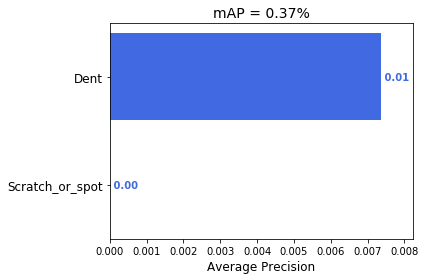

In [109]:
%run main.py

### Model trained without data augmentation 

29.41% = Dent AP 
8.82% = Scratch_or_spot AP 
mAP = 19.12%


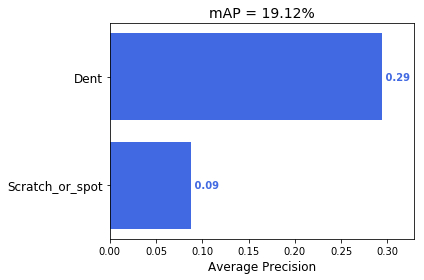

In [123]:
%run main.py

Results are comparatively better for Dent class even though it has fewer instances which might be due to the anchor sizes used. 

Data augmentation should yeild better results with more training and resources. 

These models were trained on the Colab GPU and each took about 12 hours for nearly 100 epochs but clearly we need more epochs for data augmentations.

The learning could've been better with better quality data as only 276/551 training images and 24/50 test images had the objects/classes to be detected.

This was my first attempt at Faster RCNN and indeed a great learning experience. A lot of improvements can still be made (ofcourse more resources and whatnot) and I'm already on it.

**Adjustments made**

*   epochs: 100 
*   Image Size : 300 from 600 originally 
*   Anchor Size :  [64, 128, 256] instead of [128, 256, 512]




## Edits in files (Rough Work)

In [0]:
%%writefile keras_frcnn/config.py

from keras import backend as K
import math

class Config:

	def __init__(self):

		self.verbose = True

		self.network = 'resnet50'

		# setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# anchor box scales
		self.anchor_box_scales = [64, 128, 256]    ##  instead of [128, 256, 512]

		# anchor box ratios
		self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]

		# size to resize the smallest side of the image
		self.im_size = 300      ## instead of 600

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 4

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 16

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		#location of pretrained weights for the base network 
		# weight files can be found at:
		# https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels_notop.h5
		# https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

		self.model_path = 'model_frcnn.vgg.hdf5'

Overwriting keras_frcnn/config.py


In [122]:
%%writefile test_frcnn.py


from __future__ import division
import os
import cv2
import numpy as np
import sys
import pickle
import pandas as pd
from optparse import OptionParser
import time
from keras_frcnn import config
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers
from google.colab.patches import cv2_imshow

sys.setrecursionlimit(40000)

parser = OptionParser()

parser.add_option("-p", "--path", dest="test_path", help="Path to test data.")
parser.add_option("-n", "--num_rois", type="int", dest="num_rois",
				help="Number of ROIs per iteration. Higher means more memory use.", default=32)
parser.add_option("--config_filename", dest="config_filename", help=
				"Location to read the metadata related to the training (generated when training).",
				default="config.pickle")
parser.add_option("--network", dest="network", help="Base network to use. Supports vgg or resnet50.", default='resnet50')

(options, args) = parser.parse_args()

if not options.test_path:   # if filename is not given
	parser.error('Error: path to test data must be specified. Pass --path to command line')


config_output_filename = options.config_filename

with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

if C.network == 'resnet50':
	import keras_frcnn.resnet as nn
elif C.network == 'vgg':
	import keras_frcnn.vgg as nn

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

img_path = options.test_path

def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

class_mapping = C.class_mapping

if 'bg' not in class_mapping:
	class_mapping['bg'] = len(class_mapping)

class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}
C.num_rois = int(options.num_rois)

if C.network == 'resnet50':
	num_features = 1024
elif C.network == 'vgg':
	num_features = 512

if K.image_dim_ordering() == 'th':
	input_shape_img = (3, None, None)
	input_shape_features = (num_features, None, None)
else:
	input_shape_img = (None, None, 3)
	input_shape_features = (None, None, num_features)


img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

all_imgs = []

classes = {}

bbox_threshold = 0.8

visualise = True

for idx, img_name in enumerate(sorted(os.listdir(img_path))):
  if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
    continue
  print(img_name)
  det_res = pd.DataFrame(columns = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6'])
  i=0
  st = time.time()
  filepath = os.path.join(img_path,img_name)

  img = cv2.imread(filepath)

  X, ratio = format_img(img, C)

  if K.image_dim_ordering() == 'tf':
    X = np.transpose(X, (0, 2, 3, 1))

  # get the feature maps and output from the RPN
  [Y1, Y2, F] = model_rpn.predict(X)


  R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)

  # convert from (x1,y1,x2,y2) to (x,y,w,h)
  R[:, 2] -= R[:, 0]
  R[:, 3] -= R[:, 1]

  # apply the spatial pyramid pooling to the proposed regions
  bboxes = {}
  probs = {}

  for jk in range(R.shape[0]//C.num_rois + 1):
    ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
    if ROIs.shape[1] == 0:
      break

    if jk == R.shape[0]//C.num_rois:
      #pad R
      curr_shape = ROIs.shape
      target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
      ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
      ROIs_padded[:, :curr_shape[1], :] = ROIs
      ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
      ROIs = ROIs_padded

    [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

    for ii in range(P_cls.shape[1]):

      if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
        continue

      cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

      if cls_name not in bboxes:
        bboxes[cls_name] = []
        probs[cls_name] = []

      (x, y, w, h) = ROIs[0, ii, :]

      cls_num = np.argmax(P_cls[0, ii, :])
      try:
        (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
        tx /= C.classifier_regr_std[0]
        ty /= C.classifier_regr_std[1]
        tw /= C.classifier_regr_std[2]
        th /= C.classifier_regr_std[3]
        x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
      except:
        pass
      bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
      probs[cls_name].append(np.max(P_cls[0, ii, :]))

  all_dets = []

  for key in bboxes:
    bbox = np.array(bboxes[key])

    new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
    for jk in range(new_boxes.shape[0]):
      (x1, y1, x2, y2) = new_boxes[jk,:]

      (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
      row = [key, new_probs[jk], real_x1, real_y1, real_x2, real_y2]
      det_res.loc[i] = row
      i = i+1

      cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),2)

      textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
      all_dets.append((key,100*new_probs[jk]))

      (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
      textOrg = (real_x1, real_y1-0)

      cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
      cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
      cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

  print('Elapsed time = {}'.format(time.time() - st))
  print(all_dets)
  det_path = 'input/detection-results/' + img_name[:-3] + 'txt'
  det_res.to_csv(det_path, header=None, index=None, sep=' ')
  #cv2_imshow(img)
  #cv2.waitKey(0)
  cv2.imwrite('results_imgs/{}.png'.format(idx),img)

Overwriting test_frcnn.py


In [0]:
# records_df.columns = ['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr']
# r_epochs = 100
# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
# plt.title('mean_overlapping_bboxes')
# plt.subplot(1,2,2)
# plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
# plt.title('class_acc')

# plt.show()

# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
# plt.title('loss_rpn_cls')
# plt.subplot(1,2,2)
# plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
# plt.title('loss_rpn_regr')
# plt.show()


# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
# plt.title('loss_class_cls')
# plt.subplot(1,2,2)
# plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
# plt.title('loss_class_regr')
# plt.show()

# # plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
# # plt.title('total_loss')
# plt.show()